# Credit Default Analysis

## Business Understanding

### Problem Statement

### Objectives

## Data Understanding

In [1019]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, classification_report, mean_squared_error, r2_score, roc_auc_score, log_loss
!pip install xlrd
!pip install xgboost

warnings.filterwarnings('ignore')


In [759]:
df = pd.read_excel('default+of+credit+card+clients/default of credit card clients.xls', skiprows =0)

In [760]:
df.head()

,Unnamed: 0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X15,X16,X17,X18,X19,X20,X21,X22,X23,Y
0,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
1,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
2,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0


In [620]:
df.describe()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,8660.398374,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,1.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,7500.750000,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,15000.500000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,22500.250000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,30000.000000,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


In [622]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   ID                          30000 non-null  int64
 1   LIMIT_BAL                   30000 non-null  int64
 2   SEX                         30000 non-null  int64
 3   EDUCATION                   30000 non-null  int64
 4   MARRIAGE                    30000 non-null  int64
 5   AGE                         30000 non-null  int64
 6   PAY_0                       30000 non-null  int64
 7   PAY_2                       30000 non-null  int64
 8   PAY_3                       30000 non-null  int64
 9   PAY_4                       30000 non-null  int64
 10  PAY_5                       30000 non-null  int64
 11  PAY_6                       30000 non-null  int64
 12  BILL_AMT1                   30000 non-null  int64
 13  BILL_AMT2                   30000 non-null  int64
 14  BILL_A

In [624]:
df.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month'],
      dtype='object')

## Data Cleaning

In [626]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

In [628]:
df = df.drop(columns = ['id'])

In [630]:
df.head()

,limit_bal,sex,education,marriage,age,pay_0,pay_2,pay_3,pay_4,pay_5,...,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default_payment_next_month
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [632]:
df.isna().sum()

limit_bal                     0
sex                           0
education                     0
marriage                      0
age                           0
pay_0                         0
pay_2                         0
pay_3                         0
pay_4                         0
pay_5                         0
pay_6                         0
bill_amt1                     0
bill_amt2                     0
bill_amt3                     0
bill_amt4                     0
bill_amt5                     0
bill_amt6                     0
pay_amt1                      0
pay_amt2                      0
pay_amt3                      0
pay_amt4                      0
pay_amt5                      0
pay_amt6                      0
default_payment_next_month    0
dtype: int64

In [633]:
df.duplicated().sum()

35

In [636]:
df = df.drop_duplicates()

In [638]:
df.duplicated().sum()

0

In [640]:
df.dtypes

limit_bal                     int64
sex                           int64
education                     int64
marriage                      int64
age                           int64
pay_0                         int64
pay_2                         int64
pay_3                         int64
pay_4                         int64
pay_5                         int64
pay_6                         int64
bill_amt1                     int64
bill_amt2                     int64
bill_amt3                     int64
bill_amt4                     int64
bill_amt5                     int64
bill_amt6                     int64
pay_amt1                      int64
pay_amt2                      int64
pay_amt3                      int64
pay_amt4                      int64
pay_amt5                      int64
pay_amt6                      int64
default_payment_next_month    int64
dtype: object

### Feature Engineering

In [643]:
df['totalbillamt'] = df[['bill_amt1', 'bill_amt2', 'bill_amt3', 'bill_amt4', 'bill_amt5', 'bill_amt6']].sum(axis=1)

In [645]:
df['totalpayamt'] = df[['pay_amt1', 'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6']].sum(axis=1)

In [647]:
df.head()

,limit_bal,sex,education,marriage,age,pay_0,pay_2,pay_3,pay_4,pay_5,...,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default_payment_next_month,totalbillamt,totalpayamt
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,689,0,0,0,0,1,7704,689
1,120000,2,2,2,26,-1,2,0,0,0,...,3261,0,1000,1000,1000,0,2000,1,17077,5000
2,90000,2,2,2,34,0,0,0,0,0,...,15549,1518,1500,1000,1000,1000,5000,0,101653,11018
3,50000,2,2,1,37,0,0,0,0,0,...,29547,2000,2019,1200,1100,1069,1000,0,231334,8388
4,50000,1,2,1,57,-1,0,-1,0,0,...,19131,2000,36681,10000,9000,689,679,0,109339,59049


In [649]:
# New column 'fullrepayment' where 1 means full repayment, 0 means not fully repaid
df['fullrepayment'] = (df['totalpayamt'] >= df['totalbillamt']).astype(int)
df.head()

,limit_bal,sex,education,marriage,age,pay_0,pay_2,pay_3,pay_4,pay_5,...,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default_payment_next_month,totalbillamt,totalpayamt,fullrepayment
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,689,0,0,0,0,1,7704,689,0
1,120000,2,2,2,26,-1,2,0,0,0,...,0,1000,1000,1000,0,2000,1,17077,5000,0
2,90000,2,2,2,34,0,0,0,0,0,...,1518,1500,1000,1000,1000,5000,0,101653,11018,0
3,50000,2,2,1,37,0,0,0,0,0,...,2000,2019,1200,1100,1069,1000,0,231334,8388,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,2000,36681,10000,9000,689,679,0,109339,59049,0


In [651]:
df['fullrepayment'].value_counts().unique()

array([25395,  4570], dtype=int64)

In [653]:
df['default_payment_next_month'].value_counts().unique()

array([23335,  6630], dtype=int64)

In [655]:
df['max_delay'] = df[['pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']].max(axis=1)

In [657]:
df[['max_delay']].head(15)

,max_delay
0,2
1,2
2,0
3,0
4,0
5,0
6,0
7,0
8,2
9,-1


In [659]:
df = df.drop(columns = ['pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6','pay_amt1','pay_amt2','pay_amt3','pay_amt4','pay_amt5','pay_amt6', 'bill_amt1', 'bill_amt2', 'bill_amt3', 'bill_amt4', 'bill_amt5', 'bill_amt6' ])

## EDA

In [582]:
df['limit_bal'].describe()

count      29965.000000
mean      167442.005006
std       129760.135222
min        10000.000000
25%        50000.000000
50%       140000.000000
75%       240000.000000
max      1000000.000000
Name: limit_bal, dtype: float64

In [583]:
#sns.pairplot(df)

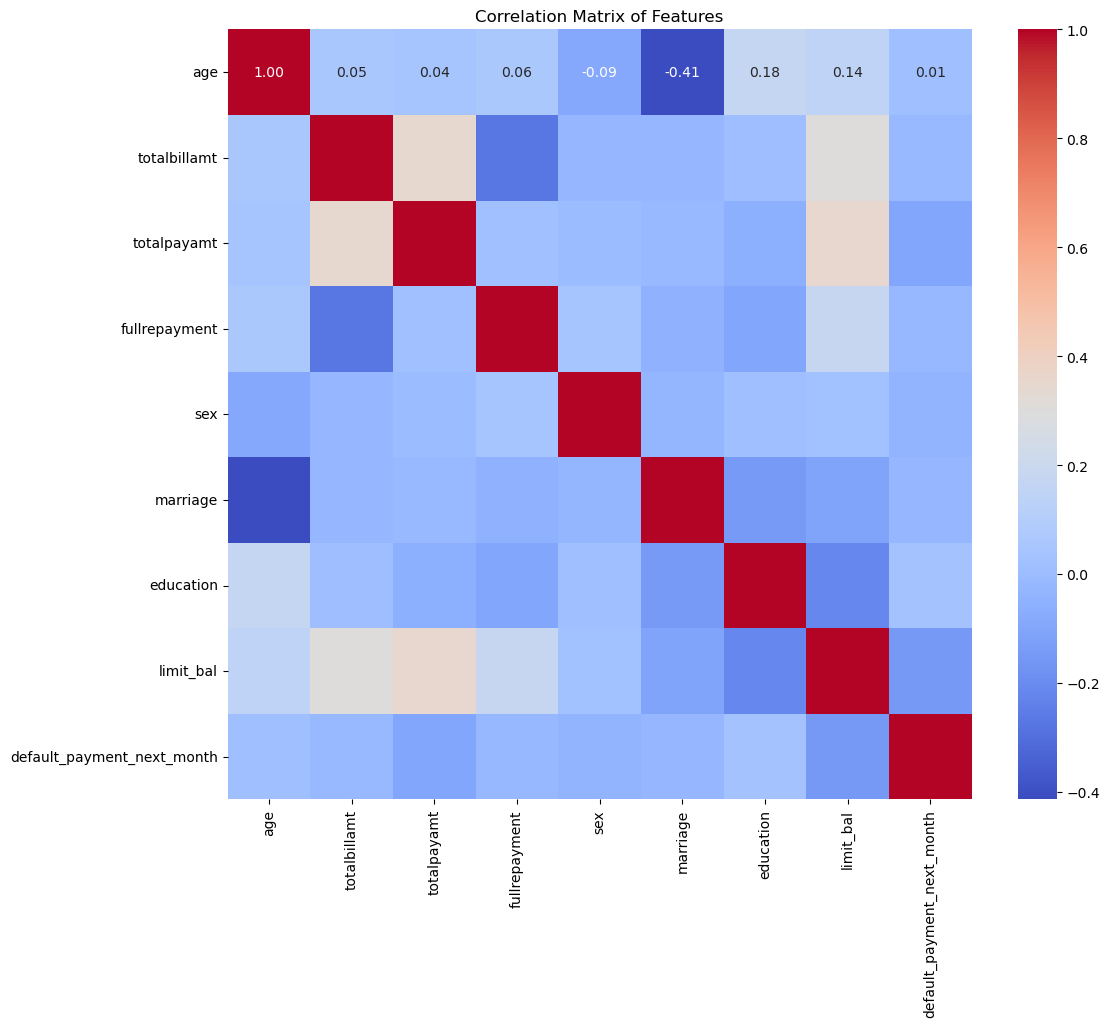

In [584]:
correlation_matrix = df[['age', 'totalbillamt', 'totalpayamt','fullrepayment', 'sex', 'marriage', 'education', 'limit_bal', 'default_payment_next_month']].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Features')
plt.show()

In [585]:
#Reverse the order of bill amounts (originally from September to April)
bill_columns = ['bill_amt6', 'bill_amt5', 'bill_amt4', 'bill_amt3', 'bill_amt2', 'bill_amt1']
months = ['Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep'] 

# Calculate the mean bill amount for each month
mean_bills = df[bill_columns].mean()

# Plot the bar graph
plt.figure(figsize=(10, 6))
sns.barplot(x=months, y=mean_bills, palette='Blues_r')

# Add labels and title
plt.xlabel('Month')
plt.ylabel('Average Bill Amount')
plt.title('Average Monthly Bill Amounts (April to September)')
plt.show()


KeyError: "None of [Index(['bill_amt6', 'bill_amt5', 'bill_amt4', 'bill_amt3', 'bill_amt2',\n       'bill_amt1'],\n      dtype='object')] are in the [columns]"

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Reverse the order of bill amounts (originally from September to April)
pay_columns = ['pay_amt6', 'pay_amt5', 'pay_amt4', 'pay_amt3', 'pay_amt2', 'pay_amt1']
months = ['Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep']  # Correct month order

# Calculate the mean bill amount for each month
mean_pay = df[pay_columns].mean()

# Plot the bar graph
plt.figure(figsize=(10, 6))
sns.barplot(x=months, y=mean_pay, palette='Blues_r')

# Add labels and title
plt.xlabel('Month')
plt.ylabel('Average Bill Amount')
plt.title('Average Monthly Bill Amounts (April to September)')
plt.show()


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select numerical columns
num_cols = ['limit_bal', 'age', 'totalbillamt', 'totalpayamt']

# Plot distribution
plt.figure(figsize=(12, 8))
for i, col in enumerate(num_cols, 1):
    plt.subplot(2, 2, i)
    sns.histplot(df[col], kde=True, bins=30, color='blue')
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()


In [ ]:
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['default_payment_next_month'], y=df['limit_bal'], palette="coolwarm")
plt.xlabel('Default (1 = Yes, 0 = No)')
plt.ylabel('Credit Limit')
plt.title('Credit Limit Distribution by Default Status')
plt.show()

In [ ]:
# Reverse order of columns (April to September)
bill_cols = ['bill_amt6', 'bill_amt5', 'bill_amt4', 'bill_amt3', 'bill_amt2', 'bill_amt1']
pay_cols = ['pay_amt6', 'pay_amt5', 'pay_amt4', 'pay_amt3', 'pay_amt2', 'pay_amt1']
months = ['Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep']

# Compute means
mean_bills = df[bill_cols].mean()
mean_payments = df[pay_cols].mean()

# Plot
plt.figure(figsize=(10, 6))
plt.bar(months, mean_bills, alpha=0.7, label='Bills', color='red')
plt.bar(months, mean_payments, alpha=0.7, label='Payments', color='green')

plt.xlabel('Month')
plt.ylabel('Average Amount')
plt.title('Average Monthly Bills vs. Payments')
plt.legend()
plt.show()


In [ ]:
df['age_group'] = pd.cut(df['age'], bins=[20, 30, 40, 50, 60, 70, 80], labels=['20s', '30s', '40s', '50s', '60s', '70+'])
age_default = df.groupby('age_group')['default_payment_next_month'].mean()

plt.figure(figsize=(8, 6))
sns.barplot(x=age_default.index, y=age_default.values, palette='viridis')
plt.xlabel('Age Group')
plt.ylabel('Default Rate')
plt.title('Default Rate by Age Group')
plt.show()

In [ ]:
plt.figure(figsize=(6, 5))
sns.countplot(x='sex', hue='default_payment_next_month', data=df, palette='coolwarm')
plt.xlabel('Sex (1 = Male, 2 = Female)')
plt.ylabel('Count')
plt.title('Gender-wise Default Distribution')
plt.legend(title='Default', labels=['No', 'Yes'])
plt.show()

In [ ]:
# Reverse the order of columns
pay_status_cols = ['pay_6', 'pay_5', 'pay_4', 'pay_3', 'pay_2', 'pay_0']
months = ['Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep']

# Calculate the mean payment status per month
pay_trends = df[pay_status_cols].mean()

plt.figure(figsize=(8, 5))
sns.lineplot(x=months, y=pay_trends, marker="o", color='purple')
plt.xlabel('Month')
plt.ylabel('Average Payment Status')
plt.title('Payment Status Trend Over Months')
plt.show()


## Preprocessing

In [957]:
df = pd.read_csv('clean.csv')
df.head()

,limit_bal,sex,education,marriage,age,default_payment_next_month,totalbillamt,totalpayamt,fullrepayment,max_delay
0,20000,2,2,1,24,1,7704,689,0,2
1,120000,2,2,2,26,1,17077,5000,0,2
2,90000,2,2,2,34,0,101653,11018,0,0
3,50000,2,2,1,37,0,231334,8388,0,0
4,50000,1,2,1,57,0,109339,59049,0,0


In [959]:
categorical_columns = ['sex', 'education', 'marriage']
df[categorical_columns] = df[categorical_columns].astype('category')

In [961]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29965 entries, 0 to 29964
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   limit_bal                   29965 non-null  int64   
 1   sex                         29965 non-null  category
 2   education                   29965 non-null  category
 3   marriage                    29965 non-null  category
 4   age                         29965 non-null  int64   
 5   default_payment_next_month  29965 non-null  int64   
 6   totalbillamt                29965 non-null  int64   
 7   totalpayamt                 29965 non-null  int64   
 8   fullrepayment               29965 non-null  int64   
 9   max_delay                   29965 non-null  int64   
dtypes: category(3), int64(7)
memory usage: 1.7 MB


In [963]:
X = df.drop(columns=['default_payment_next_month'])
y = df['default_payment_next_month']

# Convert categorical features to numerical using one-hot encoding
X = pd.get_dummies(X, drop_first=True)

In [965]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### Logistic regression

#### Before scaling and class balancing

In [969]:
# Train logistic regression model
logreg = LogisticRegression(solver='liblinear', class_weight='balanced', max_iter=200)
logreg.fit(X_train, y_train)

# Make predictions
y_pred = logreg.predict(X_test)

In [970]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r_squared = r2_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R-squared: {r_squared:.4f}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Classification Report:\n{class_report}")

Accuracy: 0.5451
Precision: 0.2867
RMSE: 0.6744
R-squared: -1.6399
Confusion Matrix:
[[2326 2341]
 [ 385  941]]
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.50      0.63      4667
           1       0.29      0.71      0.41      1326

    accuracy                           0.55      5993
   macro avg       0.57      0.60      0.52      5993
weighted avg       0.73      0.55      0.58      5993



In [971]:
from imblearn.under_sampling import TomekLinks

In [975]:
categorical_columns

['sex', 'education', 'marriage']

In [976]:
#print("Available columns:", X_train.columns)


In [979]:
#categorical_features = [X_train.columns.get_loc(col) for col in categorical_columns]

In [981]:
tomek = TomekLinks()
X_resampled, y_resampled = tomek.fit_resample(X_train, y_train)

In [982]:
# Handle class imbalance using SMOTE
#smote = SMOTE(random_state=42)
#X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

In [983]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_resampled)
X_test_scaled = scaler.transform(X_test)

In [984]:
## With scaling and class balancing
logreg = LogisticRegression(solver='liblinear', class_weight='balanced', max_iter=200)
logreg.fit(X_train_scaled, y_resampled)
y_pred = logreg.predict(X_test_scaled)
## Results
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r_squared = r2_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R-squared: {r_squared:.4f}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Classification Report:\n{class_report}")

Accuracy: 0.7309
Precision: 0.4275
RMSE: 0.5188
R-squared: -0.5621
Confusion Matrix:
[[3534 1133]
 [ 480  846]]
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.76      0.81      4667
           1       0.43      0.64      0.51      1326

    accuracy                           0.73      5993
   macro avg       0.65      0.70      0.66      5993
weighted avg       0.78      0.73      0.75      5993



In [904]:
import statsmodels.api as sm

X_train_sm = sm.add_constant(X_resampled)  # Add intercept
logit_model = sm.Logit(y_resampled, X_train_sm).fit()
print(logit_model.summary())  # Look at p-values

ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

In [989]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_resampled)
y_pred_rf = rf_model.predict(X_test_scaled)
print("Random Forest Performance:")
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

Random Forest Performance:
[[4208  459]
 [ 840  486]]
              precision    recall  f1-score   support

           0       0.83      0.90      0.87      4667
           1       0.51      0.37      0.43      1326

    accuracy                           0.78      5993
   macro avg       0.67      0.63      0.65      5993
weighted avg       0.76      0.78      0.77      5993



In [990]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(max_depth =10,n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_resampled)
y_pred_rf = rf_model.predict(X_test_scaled)
print("Random Forest Performance:")
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

Random Forest Performance:
[[4199  468]
 [ 778  548]]
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      4667
           1       0.54      0.41      0.47      1326

    accuracy                           0.79      5993
   macro avg       0.69      0.66      0.67      5993
weighted avg       0.78      0.79      0.78      5993



In [1027]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
# Try XGBoost with GridSearch
xgb_model = XGBClassifier(objective='binary:logistic', eval_metric='aucpr', use_label_encoder=False, scale_pos_weight=1)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}
grid_xgb = GridSearchCV(xgb_model, param_grid, cv=3, scoring='accuracy')
grid_xgb.fit(X_train_scaled, y_resampled)

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='aucpr', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=No...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7], 'n_estimators': [100, 200]},
             scoring='accuracy')

In [1033]:
# Best XGBoost Model
best_xgb = grid_xgb.best_estimator_
y_pred_proba_xgb = best_xgb.predict_proba(X_test_scaled)[:, 1]
y_pred_xgb = best_xgb.predict(X_test_scaled)
print("XGBoost Performance:")
print(confusion_matrix(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))
auc_score = roc_auc_score(y_test, y_pred_proba_xgb)
print(f"\nROC-AUC Score: {auc_score:.6f}")
log_loss_value = log_loss(y_test, y_pred_proba_xgb)
print(f"Log Loss: {log_loss_value:.6f}")

XGBoost Performance:
[[4155  512]
 [ 754  572]]
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      4667
           1       0.53      0.43      0.47      1326

    accuracy                           0.79      5993
   macro avg       0.69      0.66      0.67      5993
weighted avg       0.78      0.79      0.78      5993


ROC-AUC Score: 0.759702
Log Loss: 0.451342


In [1041]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
# Try XGBoost with GridSearch
xgb_model = XGBClassifier(objective='binary:logistic', eval_metric='aucpr', use_label_encoder=False, scale_pos_weight=1)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}
grid_xgb = GridSearchCV(xgb_model, param_grid, cv=3, scoring='accuracy')
grid_xgb.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='aucpr', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=No...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7], 'n_estimators': [100, 200]},
             scoring='accuracy')

In [1042]:
# Best XGBoost Model
best_xgb = grid_xgb.best_estimator_
y_pred_xgb = best_xgb.predict(X_test)
print("XGBoost Performance:")
print(confusion_matrix(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))

XGBoost Performance:
[[4397  270]
 [ 969  357]]
              precision    recall  f1-score   support

           0       0.82      0.94      0.88      4667
           1       0.57      0.27      0.37      1326

    accuracy                           0.79      5993
   macro avg       0.69      0.61      0.62      5993
weighted avg       0.76      0.79      0.76      5993



In [1047]:
!pip install lightgbm

   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
    --------------------------------------- 0.0/1.5 MB 1.3 MB/s eta 0:00:02
    --------------------------------------- 0.0/1.5 MB 1.3 MB/s eta 0:00:02
   - -------------------------------------- 0.1/1.5 MB 491.5 kB/s eta 0:00:03
   -- ------------------------------------- 0.1/1.5 MB 581.0 kB/s eta 0:00:03
   ---- ----------------------------------- 0.2/1.5 MB 610.0 kB/s eta 0:00:03
   ------ --------------------------------- 0.2/1.5 MB 808.4 kB/s eta 0:00:02
   ------ --------------------------------- 0.2/1.5 MB 808.4 kB/s eta 0:00:02
   ----------- ---------------------------- 0.4/1.5 MB 995.2 kB/s eta 0:00:02
   ------------- -------------------------- 0.5/1.5 MB 1.2 MB/s eta 0:00:01
   -------------- ------------------------- 0.5/1.5 MB 1.1 MB/s eta 0:00:01
   ------------------ --------------------- 0.7/1.5 MB 1.2 MB/s eta 0:00:01
   ---------------------- ----------------- 0.8/1.5 MB 1.3 MB/s eta 0:00:01
   ----

In [1055]:
!pip install --upgrade lightgbm


In [1049]:
import lightgbm as lgb

In [1059]:
from lightgbm import LGBMClassifier

In [1063]:
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# Define parameters
params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'max_depth': -1,
    'random_state': 42
}

lgb_model = LGBMClassifier(
    objective='binary',
    boosting_type='gbdt',
    learning_rate=0.05,
    num_leaves=31,
    random_state=42,
    n_estimators=100
)

lgb_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    callbacks=[lgb.early_stopping(10)]  # Change here
)

y_pred_proba = lgb_model.predict_proba(X_test)[:, 1]

# Evaluation
print("LightGBM Performance:")
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_proba))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[LightGBM] [Info] Number of positive: 5304, number of negative: 18668
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000642 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 671
[LightGBM] [Info] Number of data points in the train set: 23972, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221258 -> initscore=-1.258350
[LightGBM] [Info] Start training from score -1.258350
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[92]	valid_0's binary_logloss: 0.449367
LightGBM Performance:
ROC-AUC Score: 0.7592803649125257
[[3534 1133]
 [ 480  846]]
              precision    recall  f1-score   support

           0       0.88      0.76      0.81      4667
           1       0.43      0.64      0.51      1326

    accuracy                           0.73     

In [955]:
from sklearn.metrics import roc_auc_score

y_train_pred_proba = rf_model.predict_proba(X_train_scaled)[:, 1]
y_test_pred_proba = rf_model.predict_proba(X_test_scaled)[:, 1]

print("Train ROC-AUC:", roc_auc_score(y_resampled, y_train_pred_proba))
print("Test ROC-AUC:", roc_auc_score(y_test, y_test_pred_proba))


Train ROC-AUC: 0.8632813620845484
Test ROC-AUC: 0.7592691342990691


In [1043]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Predict probabilities
y_train_pred_proba = logit_model.predict(sm.add_constant(X_train))
y_test_pred_proba = logit_model.predict(sm.add_constant(X_test))

# Compute ROC-AUC scores
train_auc = roc_auc_score(y_train, y_train_pred_proba)
test_auc = roc_auc_score(y_test, y_test_pred_proba)

print(f"Train ROC-AUC: {train_auc:.6f}")
print(f"Test ROC-AUC: {test_auc:.6f}")

# Plot ROC Curve
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, label=f'Train ROC Curve (AUC = {train_auc:.4f})', color='blue')
plt.plot(fpr_test, tpr_test, label=f'Test ROC Curve (AUC = {test_auc:.4f})', color='red')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


ValueError: shapes (23972,17) and (10,) not aligned: 17 (dim 1) != 10 (dim 0)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Get feature importances
feature_importances = rf_model.feature_importances_

# Create DataFrame for visualization
importance_df = pd.DataFrame({
    "Feature": X_train.columns, 
    "Importance": feature_importances
}).sort_values(by="Importance", ascending=False)

# Display top features
print(importance_df.head(10))  # Top 10 features

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df["Feature"][:10], importance_df["Importance"][:10], color="skyblue")
plt.gca().invert_yaxis()  # Highest importance at the top
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Top 10 Feature Importances in Random Forest")
plt.show()


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define Random Forest model
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Define hyperparameter grid
param_grid = {
    "n_estimators": [100, 300, 500],  # Number of trees
    "max_depth": [10, 20, None],  # Tree depth
    "min_samples_split": [2, 5, 10],  # Minimum samples to split
    "min_samples_leaf": [1, 2, 4],  # Minimum samples per leaf
    "class_weight": ["balanced_subsample"]  # Handle imbalance
}

# Grid Search with 5-fold CV
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring="f1", n_jobs=-1, verbose=2)
grid_search.fit(X_train_scaled, y_train_bal)

# Best parameters
print("Best Hyperparameters:", grid_search.best_params_)

# Train RF with best params
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test_scaled)

# Performance Metrics
from sklearn.metrics import classification_report, confusion_matrix
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


## Modelling

## Model evaluation

## Conclusion and Recommendation